In [1]:
import os
cwd = os.getcwd()
os.chdir(os.path.join(cwd,'../../..'))

In [2]:
import ExMAS.utils
import ExMAS.main
import pandas as pd
import pprint
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
import numpy as np
from ExMAS.utils import inData as inData

In [3]:
params = ExMAS.utils.get_config('ExMAS/data/configs/ams-config-1.json') # load the default 
params.nP= 800
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph
inData = ExMAS.utils.load_albatross_csv(inData, params, sample=True)


In [4]:
inData = ExMAS.main(inData, params, plot = False)


17-05-21 16:34:57-INFO-Initializing pairwise trip shareability between 800 and 800 trips.
17-05-21 16:34:57-INFO-creating combinations
17-05-21 16:34:58-INFO-639200	 nR*(nR-1)
17-05-21 16:35:18-INFO-Reduction of feasible pairs by 99.60%
17-05-21 16:35:18-INFO-Degree 2 	Completed
17-05-21 16:35:18-INFO-trips to extend at degree 2 : 4981
17-05-21 16:35:28-INFO-At degree 2 feasible extensions found out of 1023 searched
17-05-21 16:35:28-INFO-Degree 3 	Completed
17-05-21 16:35:28-INFO-trips to extend at degree 3 : 1023
17-05-21 16:35:31-INFO-At degree 3 feasible extensions found out of 119 searched
17-05-21 16:35:31-INFO-Degree 4 	Completed
17-05-21 16:35:31-INFO-trips to extend at degree 4 : 119
17-05-21 16:35:31-INFO-At degree 4 feasible extensions found out of 6 searched
17-05-21 16:35:31-INFO-Degree 5 	Completed
17-05-21 16:35:31-INFO-trips to extend at degree 5 : 6
17-05-21 16:35:31-INFO-At degree 5 feasible extensions found out of 0 searched
17-05-21 16:35:31-INFO-Degree 6 	Completed

In [5]:
walk_speed = 1.389                     #m/s
walk_time  = 5                         #min
walk_dist  = round (walk_speed*60*5)   #metres

In [14]:
def pudo_requests(_inData, walk_speed = 1.389, walk_time = 5):
    
    walk_dist = round(walk_speed*60*5)
    
    pudo = pd.DataFrame(index = range(len(_inData.sblts.requests)), columns = ['pax_id', 'origin', 'origin_nodes','origin_dist',\
                                                                               'destination','destination_nodes','destination_dist'])
    pudo['pax_id'] = _inData.sblts.requests['index']
    pudo['origin'] = _inData.sblts.requests['origin'].tolist()
    pudo['destination'] = _inData.sblts.requests['destination'].tolist()
    pudo = pudo.astype(object)
    for i in range(len(pudo)):
        #origins = _inData.skim[pudo.iloc[i]['origin']][(_inData.skim[pudo.iloc[i]['origin']]<walk_dist) & (_inData.skim[pudo.iloc[i]['origin']]>0)].sort_values()                 #excludes original origin as PUDO point
        origins = _inData.skim[pudo.iloc[i]['origin']][(_inData.skim[pudo.iloc[i]['origin']]<walk_dist)].sort_values()                                                             # everything in walk_dist radius
        
        #destinations = _inData.skim[pudo.iloc[i]['destination']][(_inData.skim[pudo.iloc[i]['destination']]<walk_dist) & _inData.skim[pudo.iloc[i]['destination']]>0].sort_values()
        destinations = _inData.skim[pudo.iloc[i]['destination']][(_inData.skim[pudo.iloc[i]['destination']]<walk_dist)].sort_values()
        
        pudo.at[i,'origin_nodes'] = list(origins.index)
        pudo.at[i,'destination_nodes'] = list(destinations.index)
        
        origins =  list(map(lambda x: round(x/walk_speed), origins.tolist()))
        destinations = list(map(lambda x: round(x/walk_speed), destinations.tolist()))                 #check this marko
        
        pudo.at[i,'origin_dist']  = origins
        pudo.at[i,'destination_dist'] = destinations
        
    _inData.pudo = pudo
    
    return _inData


In [7]:
  
def plot_map_rides(inData, ride_indexes, light=True, m_size=30, lw=3, fontsize = 10, figsize = (40,40)):
    import seaborn as sns

    from matplotlib.collections import LineCollection

    def make_schedule(t, r, p):
        columns = ['node', 'times', 'req_id','pudo_nodes', 'od']
        degree = 2 * len(t.indexes)
        df = pd.DataFrame(None, index=range(degree), columns=columns)
        x = t.indexes_orig
        s = [r.loc[i].origin for i in x] + [r.loc[i].destination for i in x]
        p = [p.iloc[i].origin_nodes for i in x] + [p.iloc[i].destination_nodes for i in x]      #retrieving pudo locs from PUDO DF
        df.node = pd.Series(s)                                                                                    # adding pudo to DF
        df.pudo_nodes = pd.Series(p)
        df.req_id = x + t.indexes_dest
        df.times = t.times
        df.od = pd.Series(['o'] * len(t.indexes) + ['d'] * len(t.indexes))
        return df


    def add_route(ax, route, color='grey', lw=2, alpha=0.5):
        # plots route on the graph alrready plotted on ax
        edge_nodes = list(zip(route[:-1], route[1:]))
        lines = []
        for u, v in edge_nodes:
            # if there are parallel edges, select the shortest in length
            data = min(G.get_edge_data(u, v).values(), key=lambda x: x['length'])
            # if it has a geometry attribute (ie, a list of line segments)
            if 'geometry' in data:
                # add them to the list of lines to plot
                xs, ys = data['geometry'].xy
                lines.append(list(zip(xs, ys)))
            else:
                # if it doesn't have a geometry attribute, the edge is a straight
                # line from node to node
                x1 = G.nodes[u]['x']
                y1 = G.nodes[u]['y']
                x2 = G.nodes[v]['x']
                y2 = G.nodes[v]['y']
                line = [(x1, y1), (x2, y2)]
                lines.append(line)
        lc = LineCollection(lines, colors=color, linewidths=lw, alpha=alpha, zorder=3)
        ax.add_collection(lc)

    s = inData.sblts.rides
    r = inData.sblts.requests
    G = inData.G
    p  = inData.pudo
    ts = [make_schedule(s.iloc[ride_index],r,p) for ride_index in ride_indexes]

    # t1 = make_schedule(s.iloc[1], r)
    # t2 = make_schedule(s[s.kind == 20].iloc[1], r)
    #t3 = make_schedule(s[s.kind == 31].iloc[3], r)



    G = inData.G
    fig, ax = ox.plot_graph(G, figsize=figsize, node_size=0, edge_linewidth=0.3,
                            show=False, close=False,
                            edge_color='grey',  bgcolor='white')

    #colors = {1: 'navy', 2: 'teal', 3: 'maroon', 4: 'black', 5: 'green', 6:'teal'}
    colors = sns.color_palette("Set2",6)


    for t in ts:

        orig_points_lats, orig_points_lons, dest_points_lats, dest_points_lons = [], [], [], []
        deg = t.req_id.nunique()
        count = 0
        for i in t.req_id.unique():
            count += 1
            r = t[t.req_id == i]

            o = r[r.od == 'o'].iloc[0].node
            d = r[r.od == 'd'].iloc[0].node
            
            o_pudo = r[r.od == 'o'].iloc[0].pudo_nodes
            d_pudo = r[r.od == 'd'].iloc[0].pudo_nodes

            if not light:
                ax.annotate('o' + str(i), (G.nodes[o]['x'] * 1.0001, G.nodes[o]['y'] * 1.00001), fontsize = fontsize,
                    bbox = dict(facecolor='white', alpha=0.7, edgecolor='none'))
                ax.annotate('d' + str(i), (G.nodes[d]['x'] * 1.0001, G.nodes[d]['y'] * 1.00001), fontsize = fontsize,
                    bbox = dict(facecolor='white', alpha=0.7, edgecolor='none'))
            route = nx.shortest_path(G, o, d, weight='length')
            add_route(ax, route, color='black', lw=lw / 2, alpha=0.3)
            ax.scatter(G.nodes[o]['x'], G.nodes[o]['y'], s=m_size, c=[colors[deg]], marker='o')
            ax.scatter(G.nodes[d]['x'], G.nodes[d]['y'], s=m_size, c=[colors[deg]], marker='>')
            for o_p in o_pudo:
                ax.scatter(G.nodes[o_p]['x'], G.nodes[o_p]['y'], s=m_size,alpha = 1, c=[colors[deg]], marker='x')
            for d_p in d_pudo:
                ax.scatter(G.nodes[d_p]['x'], G.nodes[d_p]['y'], s=m_size,alpha = 1, c=[colors[deg]], marker='x')
        routes = list()  # ride segments
        o = t.node.values[0]
        for d in t.node.values[1:]:
            routes.append(nx.shortest_path(G, o, d, weight='length'))
            o = d
        for route in routes:
            add_route(ax, route, color=[colors[deg]], lw=lw, alpha=0.7)
    plt.tight_layout()
    plt.savefig('map.png', dpi = 300)

In [8]:
def ride_to_pudo_graph(ride, inData, door = False):                                                    # function converts skim of PUDO locations between requests to a dictionary. 
    
    graph = {}                                                                   # The skim of two requests is saved in graph, ordered as indexes_origin + indexes_destination
    for i,trip_o in enumerate(ride.indexes):
        #O_0 = inData.pudo.iloc[r.indexes[0]].origin
        if i<(len(ride.indexes)-1):
            O_0 = inData.pudo.iloc[ride.indexes[i]].origin_nodes
            O_1 = inData.pudo.iloc[ride.indexes[i+1]].origin_nodes

            D_0 = inData.pudo.iloc[ride.indexes_dest[i]].destination_nodes
            D_1 = inData.pudo.iloc[ride.indexes_dest[i+1]].destination_nodes
            graph[i]  = inData.skim.loc[O_0][O_1]

            graph[i+(len(ride.indexes))] = inData.skim.loc[D_0][D_1]
        else:
            O_0 = inData.pudo.iloc[ride.indexes[-1]].origin_nodes
            D_0 = inData.pudo.iloc[ride.indexes_dest[0]].destination_nodes
            graph[i]  = inData.skim.loc[O_0][D_0]
    for j,g in enumerate(graph):
        graph[j] = graph[j].stack().sort_values()                              # sort skim distances from least to greatest
    if door == True:                                                                     #condition for first pick-up/ last drop-off to be at door
        graph[0] = graph[0].loc[inData.pudo.iloc[ride.indexes[0]].origin]                #first passenger picked up from door
        graph[j] = graph[j][:,inData.pudo.iloc[ride.indexes_dest[i]].destination]        #last passenger dropped off at door
    
    return graph                                                               # Size of graph indeces is (len(indexes_origin + indexes_destination) -1)

# Two Trips

In [9]:
def two_degree_pudo(_graph, r, limit = 10000, access_time = 20, egress_time = 10):
    trip_order  = r.indexes_orig + r.indexes_dest
    distances      = [0]*(len(trip_order)-1)                                                #Empty list to store distances between nodes, will constantly be overwritten
    nodes          = [0]*(len(trip_order))                                                                  #Empty list to store the optimal PUDO locations   
    acc_egr_times = []                                                                      #empty list to store access egress times
    acc_egr_times_pred = []                                                                 #empty list used to compare access egress times
    
    walking_times = []                                                                      #empty list to store walking times to nodes
    
    predecessor = [float('inf')]                                                            #Stores the theoretical minium
    counter     = 0

    for i, d_0 in _graph[0].iteritems():                                                    # iterate through every row in graph, i is nodes and d_0 is distance between nodes
        if counter >= limit:                                                                #break once iteration counter reaches limit
            break        
        nodes_0 = i                                                                         # nodes are in form of [x_1,x_2] or [O,D] respectively
        distances[0]=d_0                                                                    # Save distance to list
        for j, d_1 in _graph[1].loc[i[1]].iteritems():                                      # Next trip with origin now from x_2
            if counter >= limit:
                break
                                                   
            nodes_1 = j                                                                    # node is now single int value
            distances[1]= d_1                                                             

            if sum(predecessor)< sum(distances):                                           # break loop if distance thus far is greater than total distance from predecessor
                distances[1] = 0                                                           # reset specific distance to 0
                counter = counter + 1                                                      # record iteration
                break

            for k, d_2 in _graph[2].loc[j].iteritems():
                
                nodes_2 = k
                distances[2]= d_2
                
                acc_egr_times = []                                                        #reset list of access and egress times
                acc_egr_times.append(access_time)                                         #first passenger picked up will have an a-time
                
                for p in distances[:len(distances)//2]:                                   #looking only at picked up travellers             
                    if p!=0:                                                              #see whether travellers were picked up from common meeting point
                        acc_egr_times.append(access_time)
                    else:
                        acc_egr_times.append(0)                                           #assign access time of zero is passenger picked up from common meeting point
                for p in distances[len(distances)//2:]:                                   #looking only at dropped off travellers
                    if p!=0:
                        acc_egr_times.append(egress_time)
                    else:
                        acc_egr_times.append(0)                                           #egress time of zero is passengers dropped at common point
                
                #print(sum(distances), sum(predecessor),counter)
                if sum(predecessor)+sum(acc_egr_times_pred)< sum(distances)+sum(acc_egr_times):     #previous compared to newly saved distance
                    distances[2] = 0                                                                #if new distance larger than predecessor, set specific distance value to zero
                    counter = counter + 1
                    break                                                                           # break loop to test another combination
                    
                elif sum(predecessor)+sum(acc_egr_times_pred)> sum(distances)+sum(acc_egr_times):   # previous compared to newly saved distance
                    predecessor = distances.copy()                                                  # if new distance is smaller than pred., save copy of new distance
                    acc_egr_times_pred = acc_egr_times.copy()                                       # save list of access/ egress times
                    nodes[0]    = nodes_0[0]                                                        # save pudo nodes
                    nodes[1]    = nodes_0[1]
                    nodes[2]    = nodes_1
                    nodes[3]    = nodes_2
                    
                    distances[2] = 0                                                               # reset specific distance
                    counter = counter + 1

                    
                                        
                    break
                    
  
            
    for no, node in enumerate(nodes):                                                             #compute walking distances to selected nodes
        if no<len(nodes)//2:
            walk = pd.DataFrame(inData.pudo.origin_dist[inData.pudo.index==trip_order[no]].iloc[0], \
                 index = inData.pudo.origin_nodes[inData.pudo.index==trip_order[no]].iloc[0])
        else:
            walk = pd.DataFrame(inData.pudo.destination_dist[inData.pudo.index==trip_order[no]].iloc[0], \
                 index = inData.pudo.destination_nodes[inData.pudo.index==trip_order[no]].iloc[0])        
        walk = walk.loc[node]
        walking_times.append(walk.iloc[0])                                                         #save walking times
    
    ttimes = list(map(lambda x: round(x/params.avg_speed), predecessor))                           #convert distances to walking times
        
    return ttimes ,  walking_times, acc_egr_times_pred, nodes

# Three trips

Sort of a brutte search algorithm, a few break commands are inserted to speed up the process. The amount of for loops are equivalent to the number of skims in 'graph', for rides with degree==3 that is 5 loops, rides with degree == 4 is 7 loops, and so on. 

Structure of commands is identical to that of a two degree ride, use two_degree_pudo to see functioning of code
 

In [41]:
def three_degree_pudo(_graph,r, limit = 6000, access_time = 20, egress_time = 10):
    trip_order  = r.indexes_orig + r.indexes_dest
    
    distances   = [0]*(len(trip_order)-1)                                                 
    nodes       = [0] *(len(trip_order))                                                                   
    
    acc_egr_times = []
    acc_egr_times_pred = []
    
    walking_times = []
    
    predecessor = [float('inf')]                                                                            
    counter     = 0                                                                                         
    
    for i, d_0 in _graph[0].iteritems():    
        if counter >= limit:
            break        
              
        nodes_0 = i                                                                                         
        distances[0]=d_0                                                                                    
 
        for j, d_1 in _graph[1].loc[i[1]].iteritems():
            if counter >= limit:
                break
            nodes_1 = j
            distances[1]=d_1

            if sum(predecessor)< sum(distances):                                                            
                distances[1] = 0                                                                            
                counter = counter + 1                                                                       
                break

            for k, d_2 in _graph[2].loc[j].iteritems():
                if counter >= limit:
                    break
                nodes_2 = k
                distances[2]=d_2

                if sum(predecessor)< sum(distances):
                    distances[2] = 0
                    counter = counter + 1
                    break

                for l, d_3 in _graph[3].loc[k].iteritems():
                    if counter >= limit:
                        break                    
                    nodes_3 = l
                    distances[3]=d_3
                    
                    if sum(predecessor)< sum(distances):
                        distances[3] = 0
                        counter = counter + 1
                        break
                    for m, d_4 in _graph[4].loc[l].iteritems():
                        nodes_4 = m
                        distances[4]= d_4
                        
                        
                        acc_egr_times = []
                        acc_egr_times.append(access_time)

                        for p in distances[:len(distances)//2]:
                            if p!=0:
                                acc_egr_times.append(access_time)
                            else:
                                acc_egr_times.append(0)
                        for p in distances[len(distances)//2:]:      
                            if p!=0:
                                acc_egr_times.append(egress_time)
                            else:
                                acc_egr_times.append(0)
                        
                        
                        if sum(predecessor)+sum(acc_egr_times_pred)< sum(distances)+sum(acc_egr_times):                                                  # eventually previous is compared to newly saved distance, if predecessor is still smaller, loop breaks
                            distances[4] = 0
                            counter = counter + 1
                            break    
                        elif sum(predecessor)+sum(acc_egr_times_pred)> sum(distances)+sum(acc_egr_times):                                                 # if distances are smaller than predecessor, copy distances to predecessor and save nodes
                            predecessor = distances.copy()
                            acc_egr_times_pred = acc_egr_times.copy()
                            
                            distances[4] = 0
                            nodes[0]    = nodes_0[0]
                            nodes[1]    = nodes_0[1]
                            nodes[2]    = nodes_1
                            nodes[3]    = nodes_2
                            nodes[4]    = nodes_3
                            nodes[5]    = nodes_4
                            counter = counter + 1                            
                            break
                            

            
    for no, node in enumerate(nodes):
        if no<len(nodes)//2:
            walk = pd.DataFrame(inData.pudo.origin_dist[inData.pudo.index==trip_order[no]].iloc[0], \
                 index = inData.pudo.origin_nodes[inData.pudo.index==trip_order[no]].iloc[0])
        else:
            walk = pd.DataFrame(inData.pudo.destination_dist[inData.pudo.index==trip_order[no]].iloc[0], \
                 index = inData.pudo.destination_nodes[inData.pudo.index==trip_order[no]].iloc[0])
        walk = walk.loc[node]
        walking_times.append(walk.iloc[0])
    
    ttimes = list(map(lambda x: round(x/params.avg_speed), predecessor))
        
    return ttimes ,  walking_times, acc_egr_times_pred, nodes

# Four Trips

Pretty much the same as the code for three trips but with a couple of more for loops


In [11]:
def four_degree_pudo(_graph, r, limit = 10000, access_time = 20, egress_time = 10):
    trip_order  = r.indexes_orig + r.indexes_dest
    
    distances   = [0]*(len(trip_order)-1)                                                 #Empty list to store distances between nodes, will constantly be overwritten
    nodes       = [0] *(len(trip_order))                                                                   #Empty list to store the optimal PUDO locations
    
    acc_egr_times = []
    acc_egr_times_pred = []
    
    walking_times = []
    
    predecessor = [float('inf')]                                                                            #Stores the theoretical minium
    counter     = 0 

    for i, d_0 in _graph[0].iteritems():
        if counter >= limit:
            break
 
        nodes_0 = i
        distances[0]=d_0
        
        for j, d_1 in _graph[1].loc[i[1]].iteritems():
            if counter >= limit:
                break      
                
            
            nodes_1 = j
            distances[1]=d_1

            if sum(predecessor)< sum(distances):
                distances[1] = 0
                counter = counter + 1
                break
  
            
            for k, d_2 in _graph[2].loc[j].iteritems():
                if counter >= limit:
                    break
                
                nodes_2 = k
                distances[2]=d_2
                
                if sum(predecessor)< sum(distances):
                    distances[2] = 0
                    counter = counter + 1
                    break    

                    
                for l, d_3 in _graph[3].loc[k].iteritems():
                    if counter >= limit:
                        break         
                    
                    nodes_3 = l
                    distances[3]=d_3
                    if sum(predecessor)< sum(distances):
                        distances[3] = 0
                        counter = counter + 1
                        break
   
                        
                    for m, d_4 in _graph[4].loc[l].iteritems():
                        if counter >= limit:
                            break 
                        
                        nodes_4 = m
                        distances[4]=d_4
                        if sum(predecessor)< sum(distances):
                            distances[4] = 0
                            counter = counter + 1
                            break   
 
                        for n, d_5 in _graph[5].loc[m].iteritems():
                            if counter >= limit:
                                break                               
                            
                            nodes_5 = n
                            distances[5]= d_5
                            if sum(predecessor)< sum(distances):
                                distances[5] = 0
                                counter = counter + 1
                                break       
                                
                            for o, d_6 in _graph[6].loc[n].iteritems():
                                
                                nodes_6 = o
                                distances[6]=d_6
                                #print(sum(distances), sum(predecessor),counter)
                                
                                acc_egr_times = []
                                acc_egr_times.append(access_time)

                                for p in distances[:len(distances)//2]:
                                    if p!=0:
                                        acc_egr_times.append(access_time)
                                    else:
                                        acc_egr_times.append(0)
                                for p in distances[len(distances)//2:]:      
                                    if p!=0:
                                        acc_egr_times.append(egress_time)
                                    else:
                                        acc_egr_times.append(0)
                                
                                if sum(predecessor)+sum(acc_egr_times_pred)< sum(distances)+sum(acc_egr_times):
                                    distances[6] = 0
                                    counter = counter + 1
                                    break    
                                elif sum(predecessor)+sum(acc_egr_times_pred)> sum(distances)+sum(acc_egr_times):  
                                    predecessor = distances.copy()
                                    acc_egr_times_pred = acc_egr_times.copy()
                                    distances[6] = 0
                                    counter = counter + 1
                                    nodes[0]    = nodes_0[0]
                                    nodes[1]    = nodes_0[1]
                                    nodes[2]    = nodes_1
                                    nodes[3]    = nodes_2
                                    nodes[4]    = nodes_3
                                    nodes[5]    = nodes_4
                                    nodes[6]    = nodes_5
                                    nodes[7]    = nodes_6
                                    
                                    
                                    
                                    break
 
     
            
    for no, node in enumerate(nodes):
        if no<len(nodes)//2:
            walk = pd.DataFrame(inData.pudo.origin_dist[inData.pudo.index==trip_order[no]].iloc[0], \
                 index = inData.pudo.origin_nodes[inData.pudo.index==trip_order[no]].iloc[0])
        else:
            walk = pd.DataFrame(inData.pudo.destination_dist[inData.pudo.index==trip_order[no]].iloc[0], \
                 index = inData.pudo.destination_nodes[inData.pudo.index==trip_order[no]].iloc[0])        
        walk = walk.loc[node]
        walking_times.append(walk.iloc[0])

    ttimes = list(map(lambda x: round(x/params.avg_speed), predecessor))

    return ttimes ,  walking_times, acc_egr_times_pred,nodes

# Five Trips

In [12]:
def five_degree_pudo(_graph,r, limit = 10000, access_time = 20, egress_time = 10):
    trip_order  = r.indexes_orig + r.indexes_dest
    
    distances   = [0]*(len(trip_order)-1)                                                 #Empty list to store distances between nodes, will constantly be overwritten
    nodes       = [0] *(len(trip_order))                                                                   #Empty list to store the optimal PUDO locations
    
    acc_egr_times = []
    acc_egr_times_pred = []
    
    walking_times = []
    
    predecessor = [float('inf')]                                                                            #Stores the theoretical minium
    counter     = 0 
    
    for i, d_0 in _graph[0].iteritems():
        if counter >= limit:
            break        
        nodes_0 = i
        distances[0]=d_0
        if sum(predecessor)< sum(distances):
            break
            
        for j, d_1 in _graph[1].loc[i[1]].iteritems():
            if counter >= limit:
                break            
            
            nodes_1 = j
            distances[1]=d_1
            if sum(predecessor)< sum(distances):
                distances[1] = 0
                counter = counter +1
                break

                
            for k, d_2 in _graph[2].loc[j].iteritems():
                if counter >= limit:
                    break
                
                nodes_2 = k
                distances[2]=d_2
                if sum(predecessor)< sum(distances):
                    distances[2] = 0
                    counter = counter +1
                    break                    
                for l, d_3 in _graph[3].loc[k].iteritems():
                    if counter >= limit:
                        break
                    
                    nodes_3 = l
                    distances[3]=d_3

                    if sum(predecessor)< sum(distances):
                        distances[3] = 0
                        counter = counter +1
                        break

                        
                    for m, d_4 in _graph[4].loc[l].iteritems():
                        if counter >= limit:
                            break
                        
                        nodes_4 = m
                        distances[4]=d_4
                        #print(sum(distances), sum(predecessor))
                        if sum(predecessor)< sum(distances):
                            distances[4] = 0
                            counter = counter +1
                            break 

                        
                        for n, d_5 in _graph[5].loc[m].iteritems():
                            if counter >= limit:
                                break
                            
                            nodes_5 = n
                            distances[5]=d_5
                            if sum(predecessor)< sum(distances):
                                distances[5] = 0
                                counter = counter +1
                                break  
                                
                            for o, d_6 in _graph[6].loc[n].iteritems():
                                if counter >= limit:
                                    break
                                
                                nodes_6 = o
                                distances[6]=d_6
                                #print(sum(distances), sum(predecessor),counter)
                                if sum(predecessor)< sum(distances):
                                    distances[6] = 0
                                    counter = counter +1
                                    break 


                                for p, d_7 in _graph[7].loc[o].iteritems():
                                    if counter >= limit:
                                        break
                                    
                                    nodes_7 = p
                                    distances[7]=d_7
                                    if sum(predecessor)< sum(distances):
                                        distances[7] = 0
                                        counter = counter + 1
                                        break  


                                    for q, d_8 in _graph[8].loc[p].iteritems():
                                        
                                        nodes_8 = q
                                        distances[8]=d_8     
                                        #print(sum(distances), sum(predecessor),counter)
                                        acc_egr_times = []
                                        acc_egr_times.append(access_time)

                                        for p in distances[:len(distances)//2]:
                                            if p!=0:
                                                acc_egr_times.append(access_time)
                                            else:
                                                acc_egr_times.append(0)
                                        for p in distances[len(distances)//2:]:      
                                            if p!=0:
                                                acc_egr_times.append(egress_time)
                                            else:
                                                acc_egr_times.append(0)

                                        if sum(predecessor)+sum(acc_egr_times_pred)< sum(distances)+sum(acc_egr_times):
                                            distances[8] = 0
                                            counter = counter + 1
                                            break    
                                        elif sum(predecessor)+sum(acc_egr_times_pred)> sum(distances)+sum(acc_egr_times):  
                                            predecessor = distances.copy()
                                            acc_egr_times_pred = acc_egr_times.copy()
                                            distances[8] = 0
                                            counter = counter + 1
                                            nodes[0]    = nodes_0[0]
                                            nodes[1]    = nodes_0[1]
                                            nodes[2]    = nodes_1
                                            nodes[3]    = nodes_2
                                            nodes[4]    = nodes_3
                                            nodes[5]    = nodes_4
                                            nodes[6]    = nodes_5
                                            nodes[7]    = nodes_6
                                            nodes[8]    = nodes_7
                                            nodes[9]    = nodes_8
                                            break

            
    for no, node in enumerate(nodes):
        if no<len(nodes)//2:
            walk = pd.DataFrame(inData.pudo.origin_dist[inData.pudo.index==trip_order[no]].iloc[0], \
                 index = inData.pudo.origin_nodes[inData.pudo.index==trip_order[no]].iloc[0])
        else:
            walk = pd.DataFrame(inData.pudo.destination_dist[inData.pudo.index==trip_order[no]].iloc[0], \
                 index = inData.pudo.destination_nodes[inData.pudo.index==trip_order[no]].iloc[0])        
        walk = walk.loc[node]
        walking_times.append(walk.iloc[0])                                            
                                            
    ttimes = list(map(lambda x: round(x/params.avg_speed), predecessor))

    return  ttimes ,  walking_times, acc_egr_times_pred, nodes

In [20]:
inData = pudo_requests(inData)

# Testing

A specific ride is selected for optimisation, this specific ride is also visualised with respective PUDO points

In [31]:
r = inData.sblts.rides[inData.sblts.rides.degree!=1]
r = r[r.degree!=1]
r = r[r.degree!=2]
r = r[r.selected == 1]

                                                       #last feasbile shared ride selected
#r = r.iloc[-1]
#r = r.loc[622]
r = r.iloc[0]

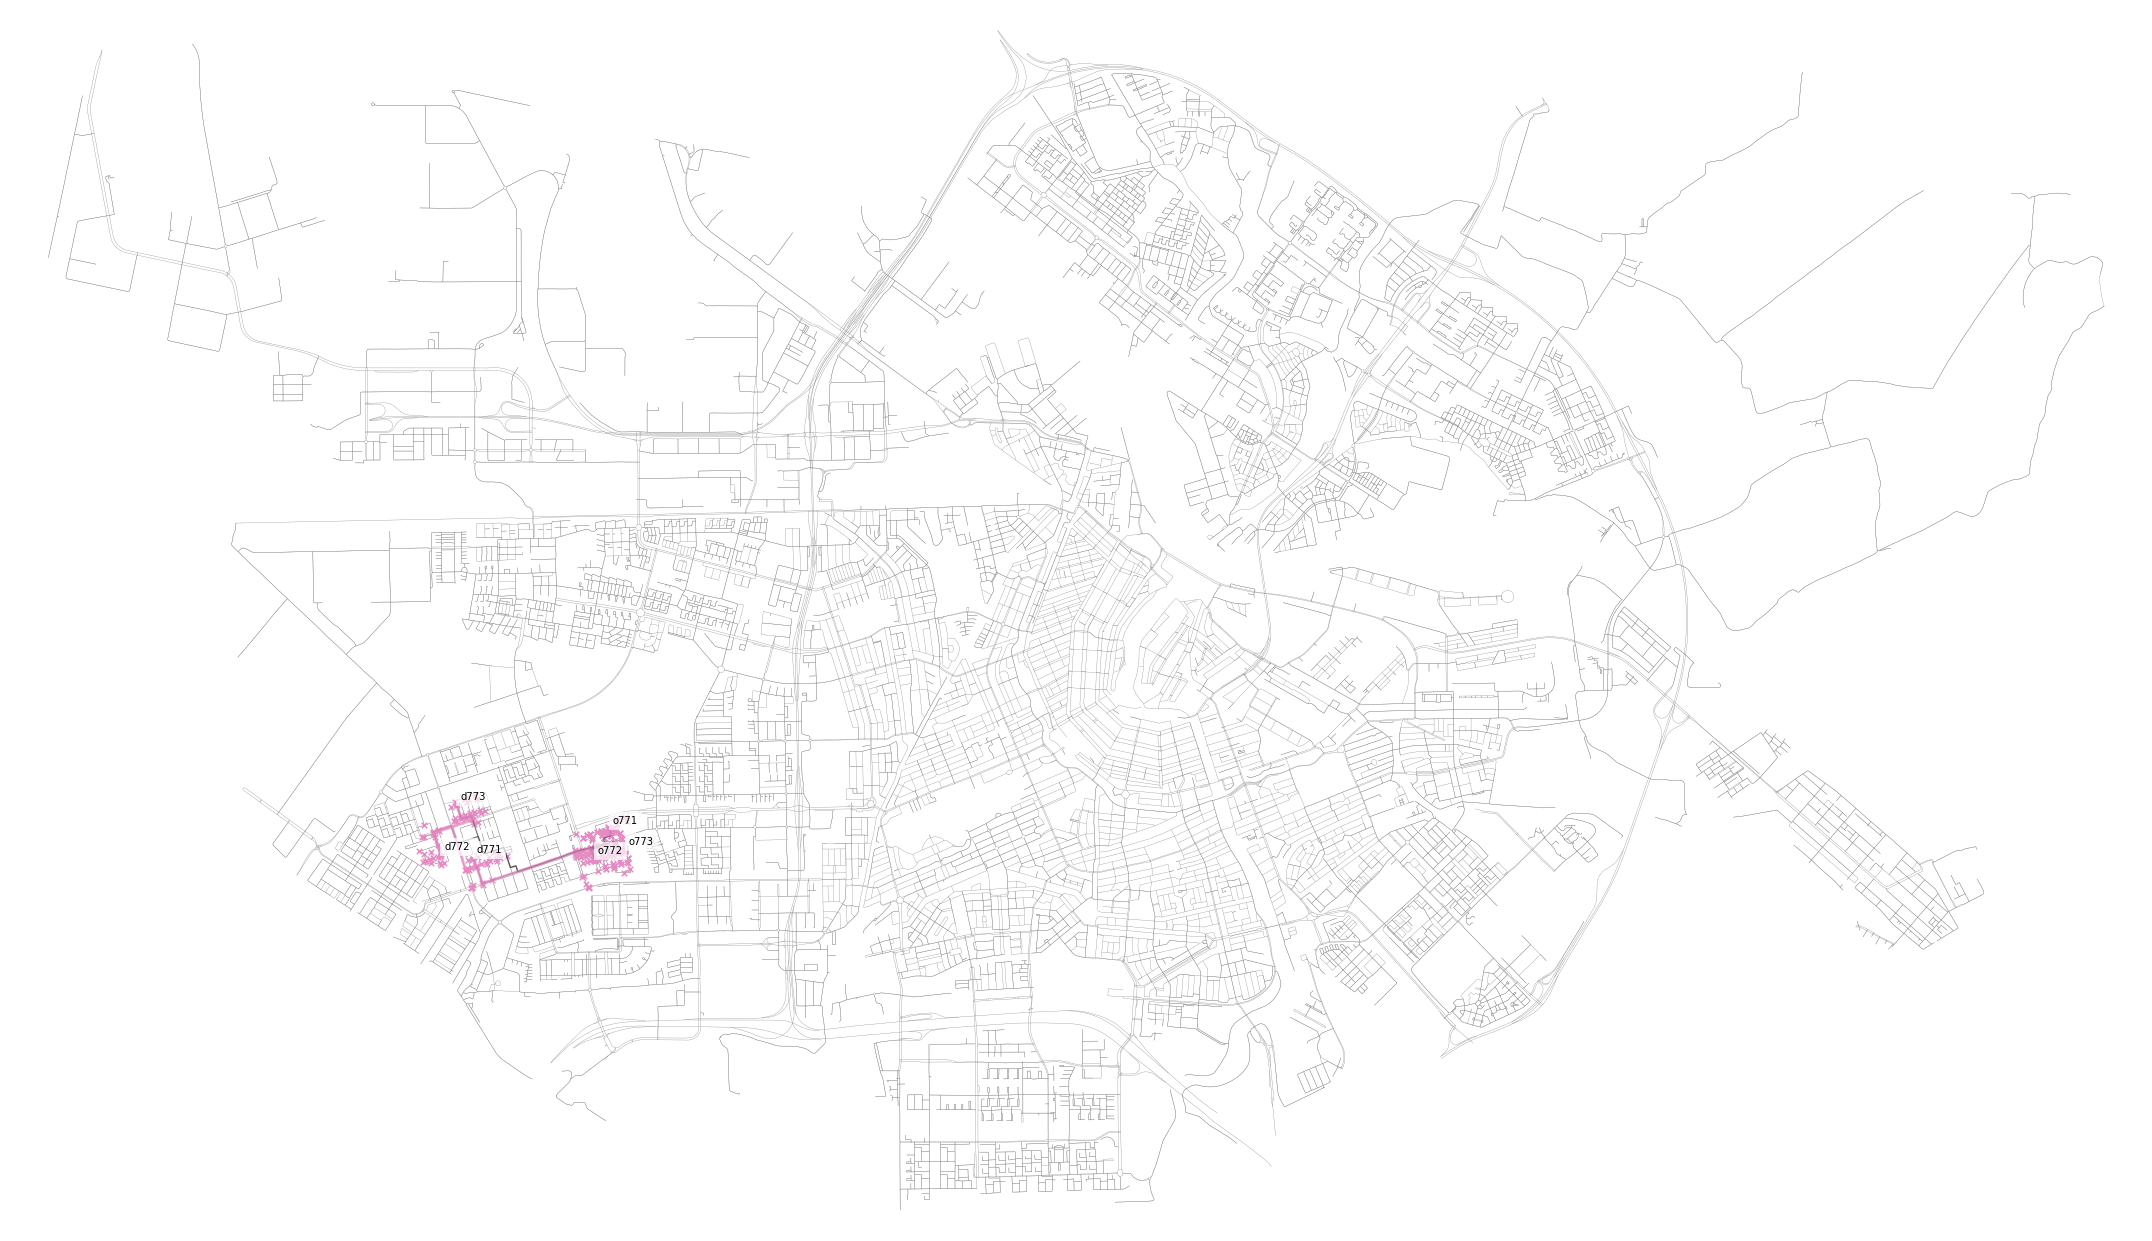

In [44]:
plot_map_rides(inData, [5933], light=False, m_size=30, lw=3, fontsize = 10, figsize = (30,30))

In [ ]:
graph = ride_to_pudo_graph(r, inData)
lim = 10000
a_time = 20
e_time = 10


# specific function assigned to specific ride degree
if len(r.indexes)==2:
    a = two_degree_pudo(graph,r, limit = lim, access_time = a_time, egress_time = e_time)

elif len(r.indexes)==3:                      
    a = three_degree_pudo(graph,r, limit = 10000, access_time = 20, egress_time = 10)

elif len(r.indexes)==4:
    a = four_degree_pudo(graph,r, limit = 10000, access_time = 20, egress_time = 10)
    
elif len(r.indexes)==5:
    a = five_degree_pudo(graph,r, limit = 10000, access_time = 20, egress_time = 10)

# All selected rides

PUDO optimisation takes place on all selected rides with degrees of three and higher, result is a large dataframe

In [42]:
df = pd.DataFrame(columns =['index','indexes','u_veh','u_veh_pudo','veh_times','indexes_orig','PUDO_orig','indexes_dest','PUDO_dest','PassHourTrav_ns','degree'])

rides = inData.sblts.rides[inData.sblts.rides.degree!=1]
rides = rides[rides.degree!=2]
rides = rides[rides.selected == 1]

for index,r in rides.iterrows():
    graph = ride_to_pudo_graph(r,inData)
    if   len(r.indexes)==2:
        a = two_degree_pudo(graph,r,limit= 10000)
    elif len(r.indexes)==3:
        a = three_degree_pudo(graph,r, limit= 10000)
    elif len(r.indexes)==4:
        a = four_degree_pudo(graph,r, limit = 20000)
    elif len(r.indexes)==5:
        a = five_degree_pudo(graph,r, limit = 20000)
    
    veh_tt_i  = a[0]                                              # list of veh travel times
    walk_tt_i = a[1]                                              # list of walk tt
    a_e_tt_i  = a[2]                                              # list of a/e tt                   
    pudo_nodes= a[3]                                              # list of nodes
    
    veh_tt = sum(a[0])                                            # sum of list of veh travel times
    walk_tt= sum(a[1])
    a_e_tt = sum(a[2])
    
    vehhour  = veh_tt+a_e_tt                                      #total vehicle travel time is sum of travel times to nodes and sum of access egress times
    passhour = veh_tt+walk_tt+a_e_tt                              # passenger travel time is total vehicle travel time and sum of walking travel time and 

    pu_nodes  = pudo_nodes[:len(pudo_nodes)//2]
    do_nodes  = pudo_nodes[len(pudo_nodes)//2:]

    d = {'index':r['index'],
        'indexes': r.indexes,
        'u_veh':r.u_veh,
         'u_veh_pudo':vehhour,
        'veh_times':veh_tt_i,
         'walk_times': walk_tt_i,
         'acc_egg_time': a_e_tt_i,
        'indexes_orig':r.indexes_orig,
        'PUDO_orig':pu_nodes,
        'indexes_dest':r.indexes_dest,
        'PUDO_dest':do_nodes,
        'PassHourTrav':int(passhour),
        'degree':len(r.indexes)}

    df = df.append(d,ignore_index=True)
df = df.set_index('index')

In [43]:
df

,indexes,u_veh,u_veh_pudo,veh_times,indexes_orig,PUDO_orig,indexes_dest,PUDO_dest,PassHourTrav_ns,degree,acc_egg_time,walk_times
index,,,,,,,,,,,,
5810,"[156, 218, 206]",2244,2190,"[83, 46, 375, 506, 1090]","[156, 218, 206]","[3309328504, 46332271, 46332486]","[206, 156, 218]","[7223707638, 46282615, 2791236365]",3552,3,"[20, 20, 20, 10, 10, 10]","[235, 283, 281, 285, 121, 157]"
5843,"[329, 355, 342]",1630,1477,"[252, 99, 201, 517, 318]","[329, 355, 342]","[46427258, 2309566346, 46351147]","[329, 342, 355]","[46317651, 46274814, 46247628]",2698,3,"[20, 20, 20, 10, 10, 10]","[0, 292, 129, 272, 274, 254]"
5871,"[524, 459, 439]",1242,1106,"[0, 0, 870, 81, 105]","[524, 459, 439]","[46454066, 46454066, 46454066]","[524, 459, 439]","[5805453834, 4546369169, 46282583]",2550,3,"[20, 0, 0, 10, 10, 10]","[270, 296, 294, 48, 299, 237]"
5932,"[59, 58, 57]",1178,898,"[143, 34, 275, 198, 158]","[59, 58, 57]","[46415902, 297970323, 46365350]","[59, 58, 57]","[46288281, 7325122864, 5481400830]",2491,3,"[20, 20, 20, 10, 10, 10]","[294, 238, 288, 279, 220, 274]"
5933,"[771, 773, 772]",552,338,"[6, 0, 133, 77, 52]","[771, 773, 772]","[46310733, 46309209, 46309209]","[771, 772, 773]","[46307578, 46321087, 46318193]",1743,3,"[20, 20, 0, 10, 10, 10]","[297, 299, 58, 291, 238, 222]"
5958,"[97, 98, 138]",1146,991,"[33, 373, 314, 0, 191]","[97, 98, 138]","[46442235, 46435792, 46344934]","[97, 98, 138]","[7014189976, 7014189976, 46273309]",2177,3,"[20, 20, 20, 10, 0, 10]","[253, 178, 293, 149, 15, 298]"
5966,"[514, 499, 508]",1644,1571,"[132, 53, 636, 154, 506]","[514, 499, 508]","[46251929, 1116749310, 46290081]","[514, 499, 508]","[46345067, 46328526, 46208132]",2933,3,"[20, 20, 20, 10, 10, 10]","[116, 279, 245, 233, 292, 197]"
6000,"[491, 600, 752]",2266,2044,"[424, 353, 292, 724, 161]","[491, 600, 752]","[1268723878, 2169205782, 1278624626]","[491, 600, 752]","[46320611, 46342469, 46291715]",3588,3,"[20, 20, 20, 10, 10, 10]","[290, 184, 297, 287, 251, 235]"
6090,"[343, 349, 472]",1307,1165,"[214, 73, 409, 312, 67]","[343, 349, 472]","[46398069, 46433317, 46451212]","[472, 343, 349]","[297096559, 46411733, 46398626]",2733,3,"[20, 20, 20, 10, 10, 10]","[238, 268, 257, 229, 284, 292]"


Positive results seen with TT. Essentially, the u_veh column represents the travel time of original exmas output while u_veh_pudo is with pudo optimisation. The latter only considers TT from pont to point and no idle/ waiting time is considered. 

At this stage PassHourTrav_ns = u_veh_pudo because walking time has not been implemented yet. I'm still examining possible approaches. 

